<h1><center>DS420: Homework 5 Spark Streaming


## Goal
In this homework, your goal to setup an end-to-end data streaming application to collect data from Twitter and analyze the data with Spark Streaming and Spark SQL. 

Firstly, we need to setup a Developer API acocunt with Twitter and create an application to get credentials. 
    
Once you have that you then need to complete the `hw5_twitterKafkaProducer.py` program in order to setup the twitter stream producer. You can verify whether the producer is up running by starting a kafka-console-consumer on the side to monitor. 

Lastly, you need to finish this notebook to setup a Spark Streaming consumer, analyze the stream in real-time, and finally visualize some of the tweeter stream activities with Pandas. Keep your producer running while working on this notebook. 

Let's get started!

In [1]:
import findspark
findspark.init('/opt/spark')

## Q1: Create a Spark session, and named it as `hw5_xxx`, where `xxx` is your last name.

In [2]:
from pyspark.sql import SparkSession


In [3]:
# Just change the appName but don't modify the configurations!

spark = SparkSession.builder.appName('hw5_moynihan')          \
                    .config('spark.jars.packages','org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1')\
                    .config('spark.jars.packages','org.apache.kafka:kafka-clients:2.4.1')\
                    .getOrCreate()


In [4]:
# Read data from kafka into a streaming DataFrame
# Ensure to supply the bootstrap server and the channel;
# and include the timestamp as you read it. 

streaming = spark.readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "localhost:9092") \
  .option("subscribe", "ds420-moynihan") \
  .option('includeTimestamp','True')\
  .load()


In [5]:
# Select only timestamp and value columns. Cast value column into String type.
streaming = streaming.selectExpr( "CAST(value AS STRING)", 'timestamp')



In [6]:
streaming.printSchema()

root
 |-- value: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)



## Q2: Run a simple query to show the raw data of the `value` column.

In [7]:
# Grab the `value` column only from the streaming DataFrame into rawValue
rawValue = streaming.select('value')



In [8]:
# Start a streaming query with rawValue

valueQuery = (rawValue.writeStream
             .format('memory')
             .queryName('valueQuery')
             .start())




In [9]:
# Poll the results every 5 seconds and show the first ten records
# Run this for 5 iterations. 

import time



for x in range(10):
    df = spark.sql('SELECT * FROM valueQuery')
    df.show(10)
    time.sleep(1)



+-----+
|value|
+-----+
+-----+

+--------------------+
|               value|
+--------------------+
|{"id": "132566892...|
|{"id": "132566892...|
|{"id": "132566893...|
|{"id": "132566893...|
+--------------------+

+--------------------+
|               value|
+--------------------+
|{"id": "132566892...|
|{"id": "132566892...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566894...|
+--------------------+

+--------------------+
|               value|
+--------------------+
|{"id": "132566892...|
|{"id": "132566892...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566893...|
|{"id": "132566894...|
+--------------------+
only showing top 10 rows

+--------------------+
|               value|
+--------------------+
|{"id": "132566892...|
|{"id": "132566892.

In [10]:
# Stop the query once it's done. 

valueQuery.stop()

## Q3: Create schema for the raw data with the hint from the printed results. 

In [11]:
from pyspark.sql.types import *

# Create the dataSchema with StructType()

dataSchema = dataSchema = StructType([ \
    StructField("id",StringType(),True), \
    StructField("user",StringType(),True), \
    StructField("follower",IntegerType(),True), \
    StructField("friends", IntegerType(), True), \
    StructField("tweet", StringType(), True), \
    StructField("hashtag", IntegerType(), True), \
    StructField("ts", TimestampType(),True), \
    StructField("retweet",IntegerType(),True), \
    StructField("favorite",IntegerType(),True) \
 
  ])



In [12]:
# Show the schema, use this as the hint to finish the question above

print(dataSchema)

StructType(List(StructField(id,StringType,true),StructField(user,StringType,true),StructField(follower,IntegerType,true),StructField(friends,IntegerType,true),StructField(tweet,StringType,true),StructField(hashtag,StringType,true),StructField(ts,TimestampType,true),StructField(retweet,IntegerType,true),StructField(favorite,IntegerType,true)))


#### Create a new column for the `streaming` DataFrame named as `json`. Use `from_json` function to parse the string in `value` column into `json` column. Save the resulting DataFrame into `df`.
`from_json` docs: [link](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.from_json)

In [13]:
from pyspark.sql.functions import *

df = streaming.withColumn('json', from_json('value', dataSchema))



In [14]:
# Checkout the schema of df. 
df.printSchema()

root
 |-- value: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- json: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- user: string (nullable = true)
 |    |-- follower: integer (nullable = true)
 |    |-- friends: integer (nullable = true)
 |    |-- tweet: string (nullable = true)
 |    |-- hashtag: string (nullable = true)
 |    |-- ts: timestamp (nullable = true)
 |    |-- retweet: integer (nullable = true)
 |    |-- favorite: integer (nullable = true)



## Q4: Generate new columns with the sub-fields from the `json` column.

#### Hint1: once the dataSchema is contructed, we can use the `.name` and `.dataType` properties to find its field name and field data type, respectively. Run the code example below.

In [15]:
for idx, field in enumerate(dataSchema): 
    print(idx, field.name, field.dataType)

0 id StringType
1 user StringType
2 follower IntegerType
3 friends IntegerType
4 tweet StringType
5 hashtag StringType
6 ts TimestampType
7 retweet IntegerType
8 favorite IntegerType


#### Hint2: notice you can use dot operator to index into the nested structure. Run the code below:

In [16]:
df.select('json.follower')

DataFrame[follower: int]

#### Also works with bracket notation.

In [17]:
df['json.follower']

Column<b'json.follower AS `follower`'>

#### Now, create new columns with all the sub-fields from the `json` column by using a for loop. 

In [18]:
for idx, field in enumerate(dataSchema): 
    a = df.withColumn(field.name, df['json.' + field.name])
    df=a

In [19]:
# Checkout the schema after the update
df.printSchema()

root
 |-- value: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- json: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- user: string (nullable = true)
 |    |-- follower: integer (nullable = true)
 |    |-- friends: integer (nullable = true)
 |    |-- tweet: string (nullable = true)
 |    |-- hashtag: string (nullable = true)
 |    |-- ts: timestamp (nullable = true)
 |    |-- retweet: integer (nullable = true)
 |    |-- favorite: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- follower: integer (nullable = true)
 |-- friends: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- hashtag: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- retweet: integer (nullable = true)
 |-- favorite: integer (nullable = true)



#### Finally, clean the `df` DataFrame so that it only contains the sub-fileds from `json` column, and the `timestamp` column

In [20]:
df = df.select(['user','id', 'follower','tweet', 'hashtag', 'ts', 'retweet', 'favorite','timestamp', 'friends'])


In [21]:
df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- follower: integer (nullable = true)
 |-- friends: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- hashtag: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- retweet: integer (nullable = true)
 |-- favorite: integer (nullable = true)



## Q5: Run a query to find the occurences of each number of 'retweet'. 

In [22]:
retweetCount =df.groupBy('retweet').count()



In [23]:
retweetQuery = retweetCount.writeStream \
                  .outputMode('complete') \
                  .format('memory') \
                  .option('truncate', 'false') \
                  .queryName('retweetQuery') \
                  .start()

In [24]:
for i in range(10):
    df_ = spark.sql('SELECT * FROM retweetQuery')
    df_.show(10)
    time.sleep(2)

+-------+-----+
|retweet|count|
+-------+-----+
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   10|
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   16|
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   25|
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   34|
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   41|
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   53|
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   59|
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   68|
+-------+-----+

+-------+-----+
|retweet|count|
+-------+-----+
|      0|   78|
+-------+-----+



## Q6: Run a windowed query to find the number of occurences for each number of 'follower'. Use window size as 20 seconds, and sliding frequency as 10 seconds.

In [ ]:
from pyspark.sql.functions import window


In [25]:
followerCount = df.groupBy(
    window(df['timestamp'],'1 minutes','30 seconds'),
    df['follower']
).count().orderBy('window')




In [26]:
followerQuery = (followerCount.writeStream
                  .outputMode('complete')
                  .format('memory')
                  .queryName('followerQuery')
                  .start()
)


In [27]:
for i in range(10):
    df_ = spark.sql('SELECT * FROM retweetQuery')
    df_.show(10)
    time.sleep(1)


+------+--------+-----+
|window|follower|count|
+------+--------+-----+
+------+--------+-----+

+------------------------------------------+--------+-----+
|window                                    |follower|count|
+------------------------------------------+--------+-----+
|[2020-11-09 00:20:00, 2020-11-09 00:20:20]|33      |1    |
|[2020-11-09 00:20:00, 2020-11-09 00:20:20]|550     |1    |
|[2020-11-09 00:20:10, 2020-11-09 00:20:30]|2220    |1    |
|[2020-11-09 00:20:00, 2020-11-09 00:20:20]|1233    |1    |
|[2020-11-09 00:20:00, 2020-11-09 00:20:20]|2220    |1    |
|[2020-11-09 00:20:00, 2020-11-09 00:20:20]|299     |1    |
|[2020-11-09 00:20:10, 2020-11-09 00:20:30]|550     |1    |
|[2020-11-09 00:20:10, 2020-11-09 00:20:30]|1233    |1    |
|[2020-11-09 00:20:00, 2020-11-09 00:20:20]|137     |2    |
|[2020-11-09 00:20:10, 2020-11-09 00:20:30]|14472   |1    |
+------------------------------------------+--------+-----+
only showing top 10 rows

+------------------------------------

## Q7: Analyze the sentiment of the tweets by using the TextBlob function.

TextBlob help doc: [link](https://textblob.readthedocs.io/en/dev/)

#### First, write a function that takes in a text input, and returns a sentiment of the input from the following array: ['negative', 'neutral', 'positive']

In [28]:
from textblob import TextBlob

def get_sentiment(text):
    textblob = TextBlob(text).sentiment.polarity
    if textblob < 0:
        return 'negative'
    elif textblob == 0:
        return 'neutral'
    elif textblob > 0:
        return 'positive'

#### Second, use a UDF function to generate a new column for the streaming DataFrame `df`.

In [29]:
from pyspark.sql.functions import udf

sentiment_udf = udf(get_sentiment, StringType())


df = df.withColumn('sentiment', sentiment_udf(df.tweet))


In [30]:
df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- follower: integer (nullable = true)
 |-- friends: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- hashtag: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- retweet: integer (nullable = true)
 |-- favorite: integer (nullable = true)
 |-- sentiment: string (nullable = true)



#### Lastly, run a query to find the count for each kind of sentiment. 

In [31]:
sentimentCount = df.groupBy('sentiment').count()



In [32]:
sentimentQuery = sentimentCount.writeStream \
                  .outputMode('complete') \
                  .format('memory') \
                  .queryName('sentimentQuery') \
                  .start()




In [33]:
# Can also use an infinitely loop instead to poll the results

for i in range(10):
    df = spark.sql('SELECT * FROM sentimentQuery')
    df.show(10)
    time.sleep(2)

+---------+-----+
|sentiment|count|
+---------+-----+
+---------+-----+

+---------+-----+
|sentiment|count|
+---------+-----+
|positive |1    |
|neutral  |3    |
|negative |1    |
+---------+-----+

+---------+-----+
|sentiment|count|
+---------+-----+
|positive |1    |
|neutral  |7    |
|negative |2    |
+---------+-----+

+---------+-----+
|sentiment|count|
+---------+-----+
|positive |6    |
|neutral  |13   |
|negative |4    |
+---------+-----+

+---------+-----+
|sentiment|count|
+---------+-----+
|positive |7    |
|neutral  |17   |
|negative |6    |
+---------+-----+

+---------+-----+
|sentiment|count|
+---------+-----+
|positive |10   |
|neutral  |20   |
|negative |8    |
+---------+-----+

+---------+-----+
|sentiment|count|
+---------+-----+
|positive |13   |
|neutral  |20   |
|negative |9    |
+---------+-----+

+---------+-----+
|sentiment|count|
+---------+-----+
|positive |19   |
|neutral  |26   |
|negative |10   |
+---------+-----+

+---------+-----+
|sentiment|count|
+-

## Q8: Show the sentiment analysis on a barplot dashboard.

In [34]:
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

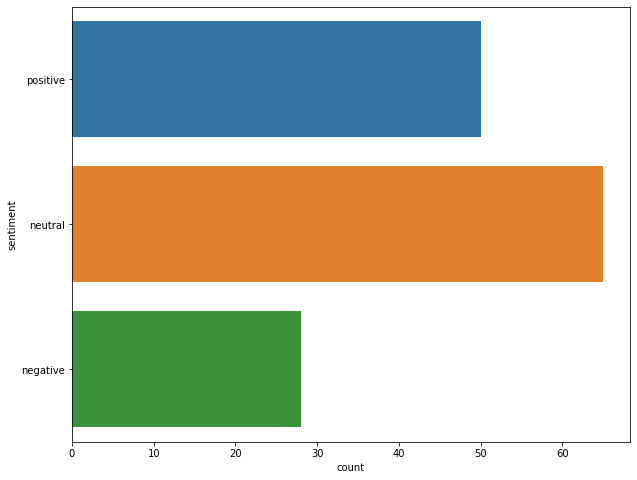

In [35]:
for i in range(10):
    df = spark.sql('SELECT * FROM sentimentQuery')
    df_pd = df.toPandas()
    display.clear_output(wait=True)
    plt.figure(figsize = (10,8))
    sns.barplot(data = df_pd, y='sentiment', x='count')
    plt.show()
    time.sleep(1)

In [36]:
# Stop all queries
retweetQuery.stop()
followerQuery.stop()
sentimentQuery.stop()

## Great Job!